# end-to-end SkimLit NLP Deep learning project

In this notebook I'll present a process of creating and learning a model which will make reading MedPub articles reading easier.

More specificially, I'm going to be replicating the deep learning model behind the 2017 paper PubMed 200k RCT: a [Dataset for Sequenctial Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071).

## Data

Since I'll be replicating the paper above, I can get it's dataset from authors GitHub https://github.com/Franck-Dernoncourt/pubmed-rct.

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [ ]:
# !dir  "./data/10_SkimLit" /b # for local env
!ls ./pubmed-rct/ # for colab

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


Data comes with 2 sets. Full set of 200k samples and it's 20k samples subset.

Start with subsample with numbers replaced with at sign.

In [ ]:
# DATA_DIR = "./data/10_SkimLit/PubMed_20k_RCT_numbers_replaced_with_at_sign/" #  for local env 
DATA_DIR = "./pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/" # for colab

In [ ]:
# !dir "./data/10_SkimLit/PubMed_20k_RCT_numbers_replaced_with_at_sign" /b # for local env
!ls  ./pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/ # for colab

dev.txt  test.txt  train.txt


Look like data is already splited into train and test sets.

### Preprocessing

In [ ]:
def read_lines(path:str) -> list:
  """
  Function takes path of a text file and returns a list of lines.
  """
  list_of_lines = []
  with open(path, "r") as file_:
    list_of_lines = file_.readlines()
  
  file_.close()
  return list_of_lines

In [ ]:
train_as_lines = read_lines(DATA_DIR + "/train.txt")

In [ ]:
train_as_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
def preprocess_data(filename: str):
  """
  Returns a list of dictionariesmof abstract line data.
  Takes in filename, read it contents and sorts by each line, extracting things
  like the target label, text of the sentence, how many sentences are in the
  current abstract and what sentence number the target line is.
  """

  input_lines = read_lines(filename) # get all kines from filename
  abstract_lines = "" # Create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop by each line in the target file
  for line in input_lines:
    if line.startswith("###"): # Chech to see if line is ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # splot abstract into separate lines
      # Iterate by each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t") # split target from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].casefold() # Get target text and casefold it
        line_data["line_number"] = abstract_line_number # what number line does the line apperars in the abstract
        line_data["total_lines"] = len(abstract_line_split) - 1 
        abstract_samples.append(line_data) # adds line to the rest of samples      

    else:
      # If the above conditions aren't fulfilled, the line contains a labeled sentence
      abstract_lines += line


  return abstract_samples


In [ ]:
train_samples = preprocess_data(DATA_DIR+'/train.txt')  
val_samples = preprocess_data(DATA_DIR+'/dev.txt')
test_samples = preprocess_data(DATA_DIR+'/test.txt')  

### Visualization

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


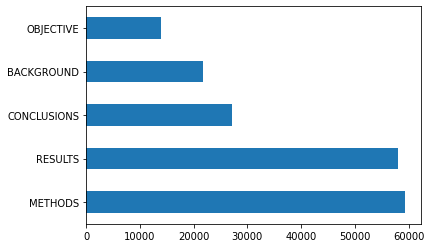

In [ ]:
# Distridution of labels in training data
train_df.target.value_counts().plot.barh()

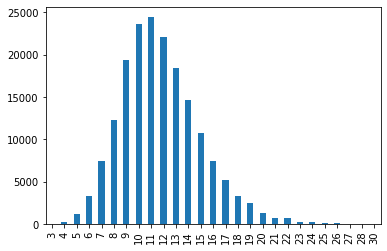

In [ ]:
# distribution of number of sentences per abstract
train_df.total_lines.value_counts().sort_index().plot.bar()

### Turn Labels into a numbers

In [ ]:
# one hot encode labels
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

### Label Encoding Labels 

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [ ]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Get the list of sentences

In [ ]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

## Modeling

### Model 0: Baseline - Multinomial Naive Bayes + TF-IDF 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
                    ("tf-idf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

In [ ]:
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [ ]:
# make baseline predictions
baseline_preds = model_0.predict(val_sentences)

In [ ]:
import utils
baseline_metrics = utils.calculate_results(val_labels_encoded, baseline_preds)

#### Preparing data for deep learning models

In [ ]:
# imports
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model

In [ ]:
# How long sentence is on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_len = np.round(np.mean(sent_lens))
avg_len

26.0

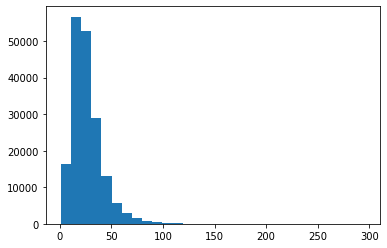

In [ ]:
# What's the distribution looks like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=30);

In [ ]:
# What sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Maximum sequence length in the traing set
max(sent_lens)

296

##### Create text vectorizer layer

How many words are in our vocab? (taken from table 2 from source [paper](https://arxiv.org/abs/1710.06071))

In [ ]:
max_tokens = 68000

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [ ]:
# Adapt thext vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n {target_sentence}")
print(f"\nLength of text:\n {len(target_sentence)}")
print(f"\nVectorized text:\n {text_vectorizer([target_sentence])}")

Text:
 this number is estimated to provide @ % power for detecting a pain reduction of one point on a numeric rating scale , with a standard deviation of one .

Length of text:
 152

Vectorized text:
 [[  23  154   20  597    6  414  817   11 3785    8   65  169    4   88
   294   18    8 3400  699  158    7    8  165 1551    4   88    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# how many words in vocab
print(f"Number of words in vocab: {len(text_vectorizer.get_vocabulary())}")

Number of words in vocab: 64841


In [ ]:
# TextVectroizer config
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

In [ ]:
token_embed = layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()),
                               output_dim=128,
                               mask_zero=True
                               )

#show example embedding
print(f"Sequence after embeding:\n { token_embed(text_vectorizer([target_sentence]))}")

Sequence after embeding:
 [[[-0.03585274 -0.02597517  0.03758522 ... -0.03576849  0.0473983
    0.03911482]
  [ 0.00684489 -0.02672559  0.04273551 ...  0.03950645  0.03818703
    0.02884546]
  [ 0.04279932  0.02901173  0.04817467 ... -0.03040074  0.04463694
    0.0055521 ]
  ...
  [-0.01917828 -0.04163956 -0.00503733 ... -0.01784277  0.00238929
   -0.02348405]
  [-0.01917828 -0.04163956 -0.00503733 ... -0.01784277  0.00238929
   -0.02348405]
  [-0.01917828 -0.04163956 -0.00503733 ... -0.01784277  0.00238929
   -0.02348405]]]


##### Creating data pipelines

In [ ]:
# Turn data infto TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
# Take the TensorSliceDataset's and turn into prefetched datasets
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.batch(32).prefetch(AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(AUTOTUNE)

test_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Model 1: Conv1D with token embeddings

In [ ]:
# Create model
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding ="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_1 = Model(inputs, outputs)

model_1.compile(
  optimizer="adam",
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [ ]:
# fit the model
history_1 = model_1.fit(train_dataset, steps_per_epoch=int(0.1 * len(train_dataset)),
                        epochs=3,
                        validation_data=val_dataset,
                        validation_steps=int(0.1 * len(val_dataset))
                        )

Epoch 1/3
562/562 [==============================] - 40s 15ms/step - loss: 0.9290 - accuracy: 0.6288 - val_loss: 0.6965 - val_accuracy: 0.7367
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6630 - accuracy: 0.7517 - val_loss: 0.6387 - val_accuracy: 0.7663
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6202 - accuracy: 0.7740 - val_loss: 0.5991 - val_accuracy: 0.7852


In [ ]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.6008 - accuracy: 0.7860


[0.6008083820343018, 0.7860121726989746]

In [ ]:
model_1preds_probs = model_1.predict(val_dataset)

In [ ]:
model_1preds = model_1preds_probs.argmax(axis=1)

In [ ]:
model_1_metrics = utils.calculate_results(val_labels_encoded, model_1preds)

### Model 2: Feature extration with USE

In [ ]:
# load USE
import tensorflow_hub as hub 
USE_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use = hub.load(USE_url)

In [ ]:
# building model
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = hub.KerasLayer(USE_url, trainable=False)(inputs)

x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes ,activation="softmax")(x)

model_2 = Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

In [ ]:
history_2 = model_2.fit(train_dataset, epochs=3,
                        steps_per_epoch=int(0.1 * len(train_dataset)),
                        validation_data=val_dataset,
                        validation_steps=int(0.1 * len(val_dataset))
                       )

Epoch 1/3
562/562 [==============================] - 16s 23ms/step - loss: 0.9181 - accuracy: 0.6474 - val_loss: 0.7954 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 12s 22ms/step - loss: 0.7683 - accuracy: 0.7018 - val_loss: 0.7525 - val_accuracy: 0.7051
Epoch 3/3
562/562 [==============================] - 13s 23ms/step - loss: 0.7508 - accuracy: 0.7118 - val_loss: 0.7370 - val_accuracy: 0.7161


In [ ]:
model_2_preds = model_2.predict(val_dataset)

In [ ]:
model_2_labels = model_2_preds.argmax(axis=1)

In [ ]:
# Eavluate model
model_2_metrics = utils.calculate_results(val_labels_encoded, model_2_labels)
model_2_metrics

{'accuracy': 71.52786972064081,
 'f1': 0.7121014301641393,
 'precision': 0.7158034397205902,
 'recall': 0.715278697206408}

### Model 3 : Conv1D with character embeddings

In [ ]:
# Function to split sentences into characters()
def split_sentences(list_of_sentences):
    chars = []
    for sentence in list_of_sentences[:]:
        chars.append(" ".join(list(sentence)))
    return chars
train_splited = split_sentences(train_sentences)
train_splited[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
val_splited = split_sentences(val_sentences)
test_splited = split_sentences(test_sentences)

In [ ]:
# What's the averge length?
chars_lens = [len(sentence) for sentence in train_sentences]
lens_mean = np.mean(chars_lens)
lens_mean

149.3662574983337

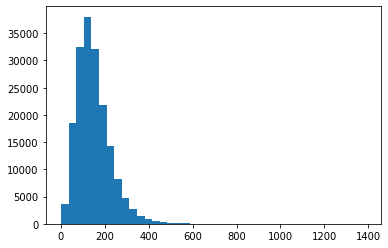

In [ ]:
# Chech the distributions
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(chars_lens, bins=40);

In [ ]:
# What character length covers 95% of sequences
output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

In [ ]:
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                   output_sequence_length=output_seq_char_len)

In [ ]:
char_vectorizer.adapt(train_splited)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 most common characters: {char_vocab[-5:]}")

Number of different characters in vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 most common characters: ['k', 'x', 'z', 'q', 'j']


#### Making a character level embedding

In [ ]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name="char_embed"
                             )

#### Build Conv1D

In [ ]:
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, 5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_3 = Model(inputs, outputs)

model_3.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

#### Create data pipelines

In [ ]:
train_splited_dataset = tf.data.Dataset.from_tensor_slices((train_splited, train_labels_one_hot)).batch(32).prefetch(AUTOTUNE)
val_splited_dataset = tf.data.Dataset.from_tensor_slices((val_splited,val_labels_one_hot)).batch(32).prefetch(AUTOTUNE)
test_splited_dataset = tf.data.Dataset.from_tensor_slices((test_splited, test_labels_one_hot)).batch(32).prefetch(AUTOTUNE)

In [ ]:
history_3 = model_3.fit(train_splited_dataset, epochs=3,
                        steps_per_epoch=int(0.1 * len(train_splited_dataset)),
                        validation_data=val_splited_dataset,
                        validation_steps=int(0.1 * len(val_splited_dataset))
                       )

Epoch 1/3
562/562 [==============================] - 7s 11ms/step - loss: 1.2471 - accuracy: 0.5040 - val_loss: 1.0203 - val_accuracy: 0.5987
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 0.9901 - accuracy: 0.6074 - val_loss: 0.9242 - val_accuracy: 0.6390
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.9188 - accuracy: 0.6398 - val_loss: 0.8692 - val_accuracy: 0.6649


In [ ]:
# Evaluate the model
model_3_preds = model_3.predict(val_splited_dataset)
model_3_labels = model_3_preds.argmax(axis=1)
model_3_metrics = utils.calculate_results(val_labels_encoded, model_3_labels)
model_3_metrics

{'accuracy': 65.59314179796107,
 'f1': 0.6447852044886577,
 'precision': 0.649109222607893,
 'recall': 0.6559314179796107}

### Model 4: Combining pretrained token embedding + characters embeddings (hybrid embeddings)

1. Create a token-level embeding model (similar `model_1`)
2. Create a character-level model (similar to `model_3`)
3. Concatenate 2 above
4. Build a series of output layers on top of 3
5. Construct a model which takes token and character-level sequences as input and produces pred probs as output.

In [ ]:
# 1. Setup token model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = hub.KerasLayer(USE_url, trainable=False)(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = Model(token_inputs, token_output)

# 2. Setup char vectors
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = Model(char_inputs, char_bi_lstm)

# 3. Concatenate 2 models
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                 char_model.output])

# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5,activation="softmax")(final_dropout)

# 5. Consturct  final model
model_4 = Model(inputs=[token_model.input, char_model.input],
               outputs=output_layer)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

In [ ]:
model_4.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
text_vectorization_1 (TextVecto (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      (None, 512)          256797824   token_input[0][0]                
____________________________________________________________________________________________

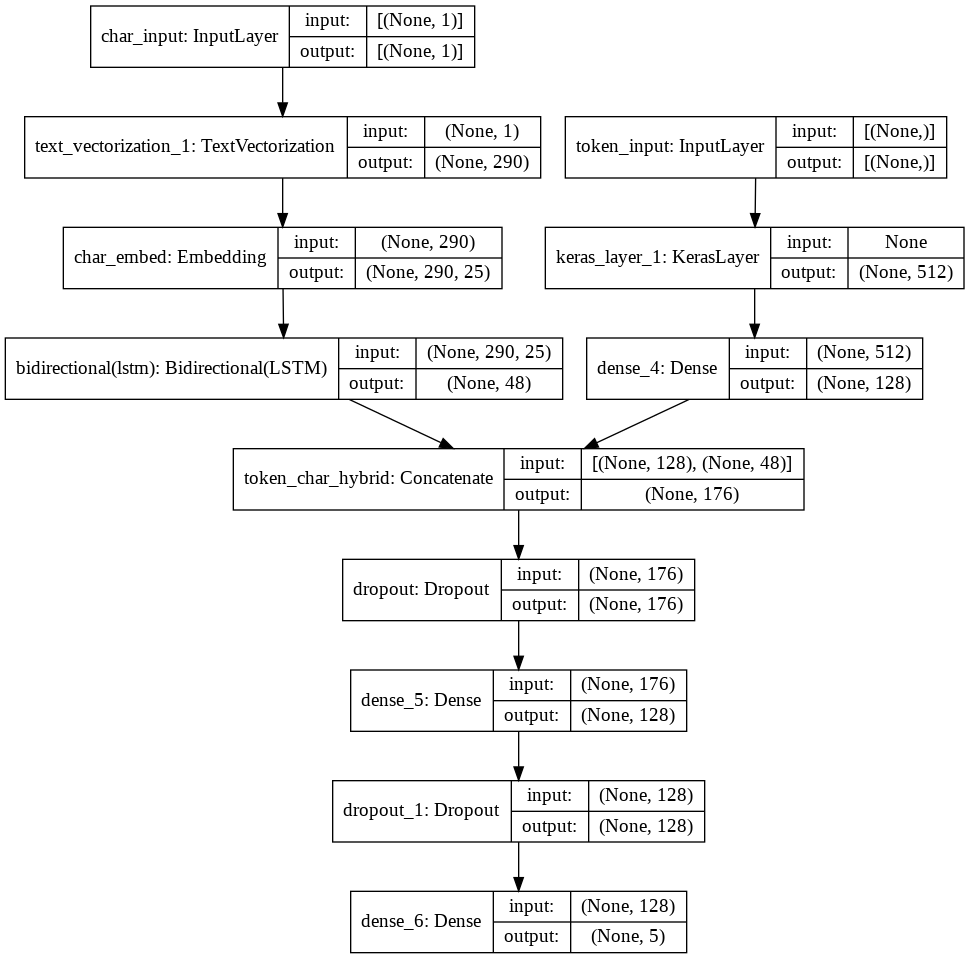

In [ ]:
# PLot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

#### Create data pipelines

In [ ]:
# Train dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_splited))
train_char_token_label = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_label))
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(AUTOTUNE)

# val dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_splited))
val_char_token_label = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_label))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(AUTOTUNE)

In [ ]:
history_4 = model_4.fit(train_char_token_dataset, epochs=3,
                        steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                        validation_data=val_char_token_dataset,
                        validation_steps=int(0.1 * len(val_char_token_dataset))
                       )

Epoch 1/3
562/562 [==============================] - 91s 139ms/step - loss: 0.9869 - accuracy: 0.6083 - val_loss: 0.7818 - val_accuracy: 0.6971
Epoch 2/3
562/562 [==============================] - 75s 133ms/step - loss: 0.8049 - accuracy: 0.6901 - val_loss: 0.7261 - val_accuracy: 0.7224
Epoch 3/3
562/562 [==============================] - 70s 125ms/step - loss: 0.7764 - accuracy: 0.7013 - val_loss: 0.6948 - val_accuracy: 0.7347


In [ ]:
# Evaluate the model
model_4_preds = model_4.predict(val_char_token_dataset)
model_4_labels = model_4_preds.argmax(axis=1)
model_4_metrics = utils.calculate_results(val_labels_encoded, model_4_labels)
model_4_metrics

{'accuracy': 73.22587051502714,
 'f1': 0.729360123829202,
 'precision': 0.7319862465309643,
 'recall': 0.7322587051502714}

### Model 5: Transfer learining with pretrained embeddings + character embeddings + positional embeddings

#### Create positional embeddings

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

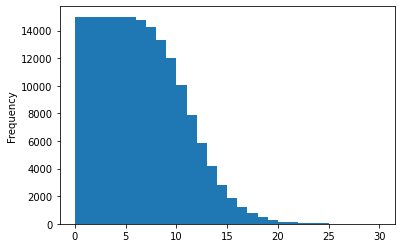

In [ ]:
train_df["line_number"].plot.hist(bins=30)

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [ ]:
# Check distripution of total lines
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

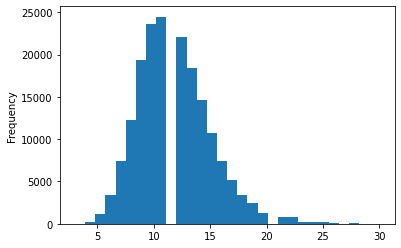

In [ ]:
train_df["total_lines"].plot.hist(bins=30)

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:5]

(TensorShape([180040, 20]), <tf.Tensor: shape=(5, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>)

#### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the `line_number` feature
4. Create a model for the `total_lines` feature
5. Combine the outputs of `1` & `2` using `tf.keras.layers.Concatenate`
5. Combine the outputs of `3, 4, 5` using `tf.keras.layers.Concatenate`
7. Create an output layer to accept the tribried embedding and output preds probs
8. Combine the inputs of `1,2,3,4` and outputs into `tf.keras.Model`

In [ ]:
# 1. Token inputs
def create_model_5():
  token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
  token_embeddings = hub.KerasLayer(USE_url, trainable=False)(token_inputs)
  token_outputs =  layers.Dense(128, activation="relu")(token_embeddings)
  token_model = tf.keras.Model(token_inputs,
                              token_outputs)

  # 2. Char inputs
  char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
  char_vectors = char_vectorizer(char_inputs)
  char_embeddings = char_embed(char_vectors)
  char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
  char_model = tf.keras.Model(char_inputs, char_bi_lstm)

  # 3. Line numbers model
  line_nums_input = layers.Input(shape=(15,), dtype=tf.float32)
  line_nums_dense = layers.Dense(32, activation="relu")(line_nums_input)
  line_nums_model = Model(line_nums_input, line_nums_dense)

  # 4. total lines model
  total_lines_input = layers.Input(shape=(20,), dtype=tf.float32)
  total_lines_dense = layers.Dense(32, activation="relu")(total_lines_input)
  total_lines_model = Model(total_lines_input, total_lines_dense)

  # 5. combine token and char embeddings into a hybrid embedding
  combined_embeddings = layers.Concatenate(name="char_token")([token_model.output,
                                                        char_model.output])
  combined_embeds_dense = layers.Dense(256, activation="relu")(combined_embeddings)
  combined_embeds_output = layers.Dropout(0.5)(combined_embeds_dense)

  # 6. Combine positional embedding with combined token and char embeddings
  tribrid_embeddings = layers.Concatenate(name="char_token_lines")([line_nums_model.output,
                                                                  total_lines_model.output,
                                                                  combined_embeds_output])
  # 7. Create output layer
  output_layer = layers.Dense(5, activation="softmax", name="output")(tribrid_embeddings)

  # 8. Put it all together

  model_5 = Model([line_nums_model.input, total_lines_model.input, token_model.input, char_model.input],
                output_layer)
  return model_5

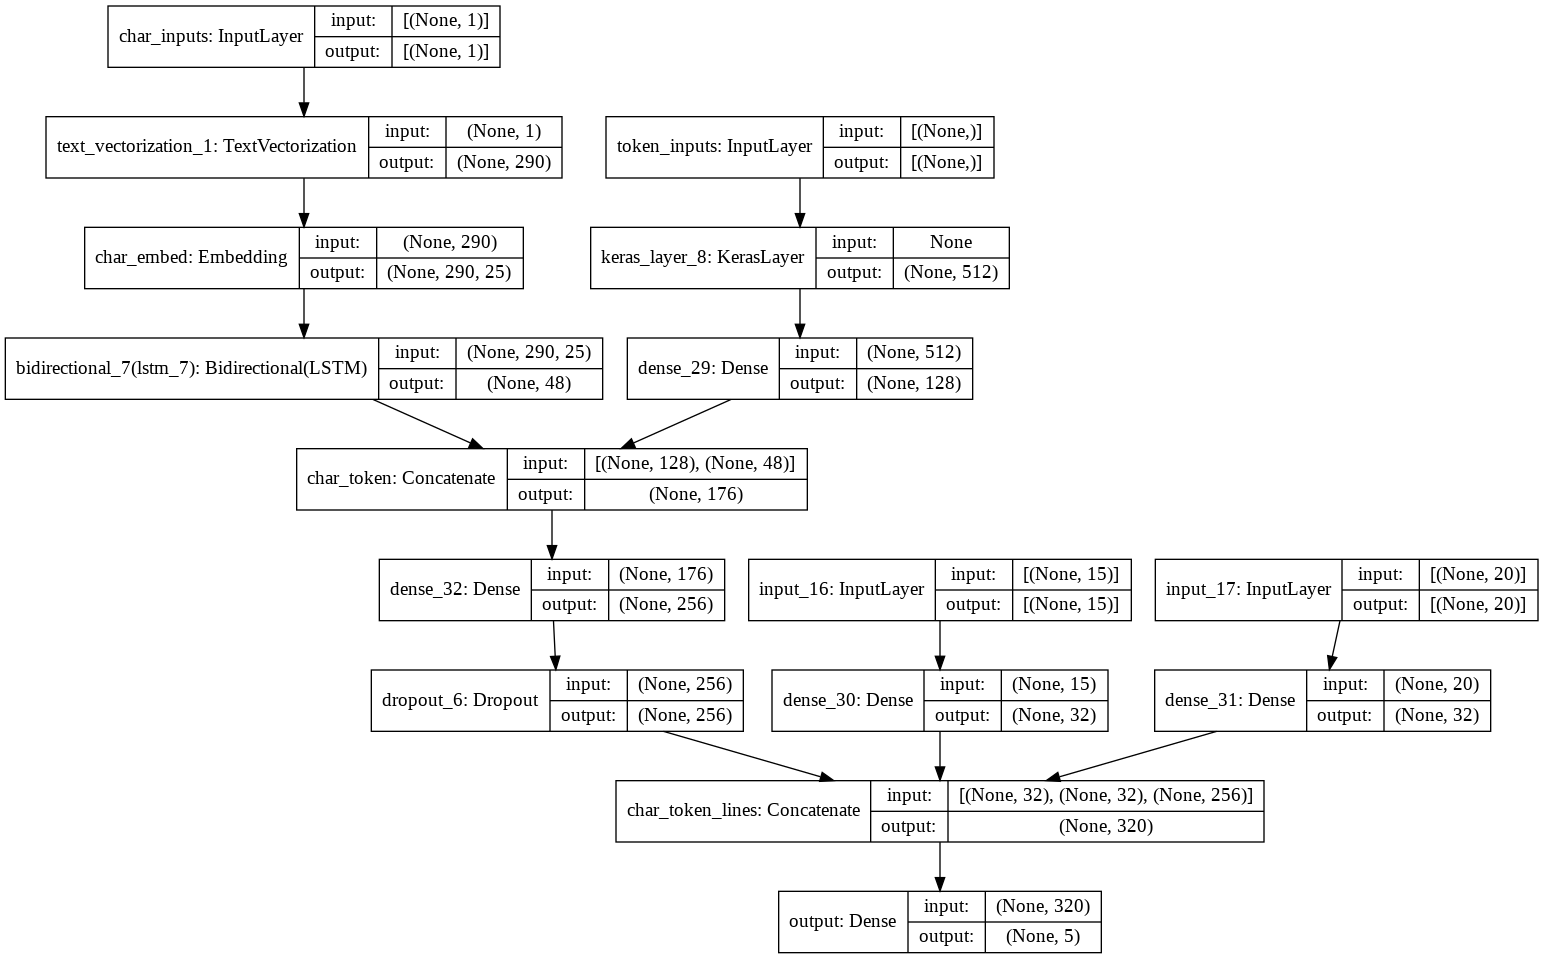

In [ ]:
# visualise the model
plot_model(model_5, show_shapes=True)

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
                )

#### Create data pipelines

In [ ]:
# Create training and validation datasets
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_splited))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(AUTOTUNE)

# repreat the same for val set
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_splited))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(AUTOTUNE)

In [ ]:
# fit the model
history_5 = model_5.fit(train_char_token_pos_dataset, epochs=3,
                        steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                        validation_data=val_char_token_pos_dataset,
                        validation_steps=int(0.1 * len(val_char_token_pos_dataset))
                       )

Epoch 1/3
562/562 [==============================] - 91s 141ms/step - loss: 1.0940 - accuracy: 0.7257 - val_loss: 0.9836 - val_accuracy: 0.8019
Epoch 2/3
562/562 [==============================] - 76s 135ms/step - loss: 0.9680 - accuracy: 0.8140 - val_loss: 0.9513 - val_accuracy: 0.8271
Epoch 3/3
562/562 [==============================] - 72s 127ms/step - loss: 0.9515 - accuracy: 0.8235 - val_loss: 0.9389 - val_accuracy: 0.8361


In [ ]:
# Evaluate the model
model_5_preds = model_5.predict(val_char_token_pos_dataset)
model_5_labels = model_5_preds.argmax(axis=1)
model_5_metrics = utils.calculate_results(val_labels_encoded, model_5_labels)
model_5_metrics

{'accuracy': 83.43373493975903,
 'f1': 0.8334195674480569,
 'precision': 0.8334061810298037,
 'recall': 0.8343373493975904}

In [ ]:
def visualuze_metrics(metrics_dicts, names_of_models, figsize=(6, 6)):
    import matplotlib.pyplot as plt
    %matplotlib inline
    df_metrics = pd.DataFrame.from_dict(metrics_dicts)
    df_metrics.index = names_of_models
    df_metrics["accuracy"] = df_metrics["accuracy"] / 100 
    df_metrics.plot.bar(figsize=figsize)
    plt.xticks(c="black", rotation="horizontal")
    plt.yticks(c="black");
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
    return df_metrics

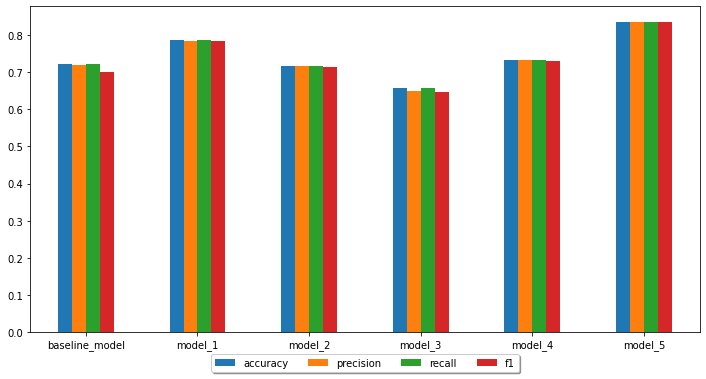

In [ ]:
metrics_df = visualuze_metrics([baseline_metrics, model_1_metrics, model_2_metrics, model_3_metrics, model_4_metrics, model_5_metrics],
                  ["baseline_model", "model_1", "model_2", "model_3", "model_4","model_5"], figsize=(12,6))

In [ ]:
# Training model 5 on 20k samples for 3 epochs
model_5_20k = create_model_5()
model_5_20k.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
                )
# fit the model
history_5_20k = model_5_20k.fit(train_char_token_pos_dataset, epochs=3,
                        steps_per_epoch=int(len(train_char_token_pos_dataset)),
                        validation_data=val_char_token_pos_dataset,
                        validation_steps=int(0.1 * len(val_char_token_pos_dataset))
                       )

Epoch 1/3
5627/5627 [==============================] - 726s 127ms/step - loss: 0.9528 - accuracy: 0.8239 - val_loss: 0.9144 - val_accuracy: 0.8418
Epoch 2/3
5627/5627 [==============================] - 710s 126ms/step - loss: 0.9081 - accuracy: 0.8541 - val_loss: 0.9054 - val_accuracy: 0.8481
Epoch 3/3
5627/5627 [==============================] - 708s 126ms/step - loss: 0.8957 - accuracy: 0.8634 - val_loss: 0.9020 - val_accuracy: 0.8521


### Final model

I'll use architecture from model_5 again but this time I'm going to train it for more epochs and add ReduceLROnPlateau, early stoping and checkpoint callbacks. 

In [ ]:
checkpoints_path = "/content/drive/MyDrive/tensorflow/checkpoints/10_SkimLit/"

In [ ]:
ckpt_callback = utils.create_checkpoint_callback(checkpoints_path +"final.ckpt",
                                 best_only=True, weights_only=True)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                          patience =0,
                                                          verbose=1,
                                                          min_lr=0.000001)
early_stopping= tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3,mode="max" )
callbacks= [ckpt_callback, reduce_lr_callback, early_stopping]

In [ ]:
# fit the model
history_5_20k = model_5_20k.fit(train_char_token_pos_dataset, epochs=20,
                        steps_per_epoch=int(len(train_char_token_pos_dataset)),
                        validation_data=val_char_token_pos_dataset,
                        validation_steps=int(0.1 * len(val_char_token_pos_dataset)),
                        callbacks=callbacks
                       )

Epoch 1/20
5627/5627 [==============================] - 715s 127ms/step - loss: 0.8870 - accuracy: 0.8701 - val_loss: 0.9009 - val_accuracy: 0.8537

Epoch 00001: val_accuracy improved from -inf to 0.85372, saving model to /content/drive/MyDrive/tensorflow/checkpoints/10_SkimLit/final.ckpt
Epoch 2/20
5627/5627 [==============================] - 712s 127ms/step - loss: 0.8799 - accuracy: 0.8754 - val_loss: 0.9015 - val_accuracy: 0.8554

Epoch 00002: val_accuracy improved from 0.85372 to 0.85539, saving model to /content/drive/MyDrive/tensorflow/checkpoints/10_SkimLit/final.ckpt

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/20
5627/5627 [==============================] - 713s 127ms/step - loss: 0.8616 - accuracy: 0.8878 - val_loss: 0.8897 - val_accuracy: 0.8644

Epoch 00003: val_accuracy improved from 0.85539 to 0.86436, saving model to /content/drive/MyDrive/tensorflow/checkpoints/10_SkimLit/final.ckpt
Epoch 4/20
5627/5627 [====================